## Reaction of OH radical attack on nitrogen groups

In [ ]:
# Install RDKit.
%%capture
!pip install rdkit

In [ ]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors as rdmd
import pandas as pd
from collections import Counter, defaultdict
import os
print(rdkit.__version__)

2025.09.1


In [ ]:
os.chdir("/content/")

file_name = 'xeno_cas5.txt'  # fazer o upload do arq TXT na pasta 'content' do Colab antes de tudo

reacao = AllChem.ReactionFromSmarts('[#8:1]-[c:2]1[c:3][c:4][c:5]([c:6][c:7]1)-[#7+](-[#8-:9])=O>>[#8:1]-[c:2]1[c:3][c:4][c:5](-[#8:9])[c:6][c:7]1')


In [ ]:
import sys
import os

# Redirect stderr to suppress RDKit warnings
sys.stderr = open(os.devnull, 'w')

# Your RDKit code that produces warnings goes here
# For example, the cell Scs5MKhi_olk

# To restore stderr:
# sys.stderr = sys.__stderr__

In [ ]:
with open(file_name, "r") as f:
    smiles = []
    for line in f:
        smiles.append(line.split('\n')[0])
        m = Chem.MolFromSmiles(line)
        ps = reacao.RunReactants((m,))
        #print(ps)
        if len(ps) > 0:
         with open('saida.txt', 'a') as g:
           try:
               Chem.SanitizeMol(ps[0][0])  #verificando a "existencia" da molecula
           except ValueError:
               g.write('')
           else:
               g.write(Chem.MolToSmiles(ps[0][0]))
               g.write('\n')
               with open('reagentes.txt', 'a') as h:
                h.write(Chem.MolToSmiles(m))
                h.write('\n')
               if len(ps) > 1:
                 with open('saida.txt', 'a') as g:
                   try:
                       Chem.SanitizeMol(ps[1][0])
                   except ValueError:
                      g.write('')
                   else:
                      g.write(Chem.MolToSmiles(ps[1][0]))
                      g.write('\n')
                      if len(ps) > 2:
                        with open('saida.txt', 'a') as g:
                          try:
                             Chem.SanitizeMol(ps[2][0])
                          except ValueError:
                              g.write('')
                          else:
                              g.write(Chem.MolToSmiles(ps[2][0]))
                              g.write('\n')

        # Add a blank line after processing each reactant
        with open('saida.txt', 'a') as g:
            g.write('\n')


In [ ]:
import os

input_file = 'saida.txt'
output_file = 'produtos.txt'

# Read the input file and process lines
with open(input_file, 'r') as infile:
    lines = infile.readlines()

processed_lines = []
previous_line_was_blank = False

for line in lines:
    stripped_line = line.strip()
    if stripped_line:
        # Add non-empty lines
        processed_lines.append(line)
        previous_line_was_blank = False
    else:
        # Add a single blank line if the previous line was not blank
        if not previous_line_was_blank:
            processed_lines.append('\n')
            previous_line_was_blank = True

# Write the processed lines to the output file
with open(output_file, 'w') as outfile:
    outfile.writelines(processed_lines)

print(f"Arquivo '{output_file}' criado com sucesso, com blocos de SMILES separados por uma única linha em branco.")

Arquivo 'produtos.txt' criado com sucesso, com blocos de SMILES separados por uma única linha em branco.



Generate the reaction output in the file "saida.txt", sanitizes them, keeps only the unique valid molecules, and writes these unique molecules line by line to a new file named "saida2.txt".

In [ ]:
unique_molecules = set()

with open('saida.txt', 'r') as f:
    for line in f:
        smiles_string = line.strip()
        if smiles_string:  # Ensure the line is not empty
            mol = Chem.MolFromSmiles(smiles_string)
            if mol is not None:
                try:
                    Chem.SanitizeMol(mol)
                    unique_smiles = Chem.MolToSmiles(mol)
                    unique_molecules.add(unique_smiles)
                except ValueError:
                    # Handle cases where sanitization fails
                    continue


## Write unique molecules

Write the unique valid molecules to a new file named `saida2.txt`.


In [ ]:
with open('saida2.txt', 'w') as g:
    for smiles in unique_molecules:
        g.write(smiles)
        g.write('\n')

## Analizing the chemical bonds

In [ ]:
# -------------------------
# CONTAGEM DE LIGAÇÕES POR PAR DE ELEMENTOS (RDKit)
# - Soma em TODOS os fragmentos
# - Converte H implícitos em H explícitos (AddHs)
# - Normaliza os pares de elementos (evita sumir O–H / N–H)
# - Pré-semeia colunas (aparecem mesmo quando 0)
# -------------------------

from rdkit import Chem
from collections import Counter
import pandas as pd

# pares alvo "brutos" (como você quer ver no CSV)
RAW_TARGET_PAIRS = [
    ("C","H"),
    ("C","C"),
    ("C","O"),
    ("O","H"),
    ("N","H"),
    ("C","N"),
    ("N","O"),
    #("O","O"),
]

# conjunto de comparação normalizado (ordem alfabética)
TARGET_PAIRS = {tuple(sorted(t)) for t in RAW_TARGET_PAIRS}

def norm_pair(a, b):
    """Retorna o par de símbolos de elemento em ordem alfabética (para comparação)."""
    return tuple(sorted((a, b)))

def display_key(p):
    """
    Converte o par normalizado (ex.: ('H','O')) para a label desejada (ex.: 'O-H').
    Regra: se houver H, imprime o outro elemento primeiro (X-H). Caso contrário, usa p[0]-p[1].
    """
    # p vem normalizado (ordem alfabética)
    if p == ("H","O"):
        return "O-H"
    if p == ("H","N"):
        return "N-H"
    return f"{p[0]}-{p[1]}"

def count_element_pairs_all_frags(smiles: str, target_pairs=TARGET_PAIRS, by_bond_order=False):
    """
    Conta ligações por par de elementos em TODOS os fragmentos do SMILES.
    - Adiciona Hs explícitos (AddHs) para capturar O–H e N–H.
    - Se by_bond_order=True, adiciona sufixo __single/__double/__triple/__aromatic.
    Retorna: dict { 'C-H': n, 'O-H': n, ... } ou com sufixos se by_bond_order=True.
    """
    counts = Counter()
    if not smiles:
        return dict(counts)

    mol = Chem.MolFromSmiles(smiles, sanitize=True)
    if mol is None:
        return dict(counts)

    frags = Chem.GetMolFrags(mol, asMols=True, sanitizeFrags=True)
    for frag in frags:
        mH = Chem.AddHs(frag)  # crucial para O–H / N–H
        for bond in mH.GetBonds():
            a1 = mH.GetAtomWithIdx(bond.GetBeginAtomIdx())
            a2 = mH.GetAtomWithIdx(bond.GetEndAtomIdx())
            p = norm_pair(a1.GetSymbol(), a2.GetSymbol())
            if p in target_pairs:
                base_key = display_key(p)

                if by_bond_order:
                    # detecta tipo de ligação
                    if bond.GetIsAromatic():
                        suffix = "aromatic"
                    else:
                        bt = bond.GetBondType()
                        if bt == Chem.BondType.SINGLE:
                            suffix = "single"
                        elif bt == Chem.BondType.DOUBLE:
                            suffix = "double"
                        elif bt == Chem.BondType.TRIPLE:
                            suffix = "triple"
                        else:
                            # fallback para tipos raros (ex.: QUADRUPLE, IONIC etc.)
                            suffix = str(bt).lower()
                    key = f"{base_key}__{suffix}"
                else:
                    key = base_key

                counts[key] += 1

    return dict(counts)

def bond_counts_df(df, react_col="reactant_smiles", prod_col="product_smiles", by_bond_order=False):
    """
    Gera um DataFrame com contagem de ligações alvo para reagentes e produtos,
    além das deltas (produto - reagente). Pré-semeia colunas com zero.
    """
    # constroi as labels base (como desejamos ver no CSV)
    base_keys = sorted(set(display_key(tuple(sorted(t))) for t in RAW_TARGET_PAIRS))
    if by_bond_order:
        ORDERS = ["single","double","triple","aromatic"]
        ALL_KEYS = [f"{k}__{o}" for k in base_keys for o in ORDERS]
    else:
        ALL_KEYS = base_keys

    rows = []
    for _, row in df.iterrows():
        rc = count_element_pairs_all_frags(row[react_col], by_bond_order=by_bond_order)
        pc = count_element_pairs_all_frags(row[prod_col],  by_bond_order=by_bond_order)

        row_dict = {
            "reactant_smiles": row[react_col],
            "product_smiles":  row[prod_col],
        }

        # inicializa todas as chaves com zero (garante presença das colunas no CSV)
        for k in ALL_KEYS:
            row_dict[f"react_{k}"] = 0
            row_dict[f"prod_{k}"]  = 0
            row_dict[f"delta_{k}"] = 0

        # preenche as contagens encontradas
        for k, v in rc.items():
            row_dict[f"react_{k}"] = v
        for k, v in pc.items():
            row_dict[f"prod_{k}"]  = v
        for k in ALL_KEYS:
            row_dict[f"delta_{k}"] = row_dict[f"prod_{k}"] - row_dict[f"react_{k}"]

        rows.append(row_dict)

    return pd.DataFrame(rows)


In [ ]:
# === Consolidação de colunas de ligações (une H-O -> O-H etc.) ===
import re
import pandas as pd
import numpy as np

VALID_ELEMS = {"C","H","O","N"}

def canonical_pair_label(a: str, b: str) -> str:
    a, b = a.upper(), b.upper()
    if a not in VALID_ELEMS or b not in VALID_ELEMS:
        return f"{a}-{b}"
    if "H" in (a, b):
        other = a if b == "H" else b
        return f"{other}-H"        # força X-H
    a2, b2 = sorted((a, b))        # sem H, ordem alfabética
    return f"{a2}-{b2}"

def parse_bond_col(colname: str):
    m = re.match(r'^(react|prod|delta)_(.+)$', colname)
    if not m:
        return None
    prefix = m.group(1)
    rest = m.group(2)
    base, order = (rest.split("__", 1) + [None])[:2]
    parts = [p.strip().upper() for p in base.split("-")]
    if len(parts) != 2:
        return None
    a, b = parts
    canon = canonical_pair_label(a, b)  # ex.: H-O -> O-H, O-C -> C-O
    return prefix, canon, (order if order else None)

def consolidate_bond_columns(df: pd.DataFrame) -> pd.DataFrame:
    groups = {}
    bond_cols = set()
    for col in df.columns:
        parsed = parse_bond_col(col)
        if parsed is None:
            continue
        bond_cols.add(col)
        prefix, canon, order = parsed
        new_name = f"{prefix}_{canon}" + (f"__{order}" if order else "")
        groups.setdefault(new_name, []).append(col)

    non_bond_cols = [c for c in df.columns if c not in bond_cols]
    out = df[non_bond_cols].copy()

    for new_name, old_list in groups.items():
        vals = pd.DataFrame({c: pd.to_numeric(df[c], errors="coerce").fillna(0) for c in old_list})
        out[new_name] = vals.sum(axis=1)

    # recalcula todos os deltas como (prod - react)
    def kp(name):
        m = re.match(r'^(react|prod|delta)_(.+)$', name)
        return m.group(1), m.group(2) if m else (None, None)

    labels = set()
    for c in out.columns:
        pref, rest = kp(c)
        if pref in {"react","prod"} and rest:
            labels.add(rest)

    for lab in labels:
        rcol, pcol, dcol = f"react_{lab}", f"prod_{lab}", f"delta_{lab}"
        r = pd.to_numeric(out.get(rcol, 0), errors="coerce").fillna(0)
        p = pd.to_numeric(out.get(pcol, 0), errors="coerce").fillna(0)
        out[dcol] = p - r

    # ordenar (opcional)
    def sort_key(c):
        parsed = parse_bond_col(c)
        if parsed is None:
            return (0, "", 0)
        pref, canon, order = parsed
        pref_rank = {"react":1, "prod":2, "delta":3}[pref]
        order_rank = {"single":1,"double":2,"triple":3,"aromatic":4}.get(order or "", 9)
        return (pref_rank, canon, order_rank)

    non_bond = [c for c in out.columns if parse_bond_col(c) is None]
    bond = sorted([c for c in out.columns if parse_bond_col(c) is not None], key=sort_key)
    return out[non_bond + bond]


In [ ]:
import pandas as pd

def bond_counts_df(df, react_col="reactant_smiles", prod_col="product_smiles", by_bond_order=False):
    # constrói a lista de chaves esperadas (para não “sumirem” quando forem 0)
    base_keys = [f"{a}-{b}" for (a,b) in sorted(TARGET_PAIRS)]
    if by_bond_order:
        ORDERS = ["single","double","triple","aromatic"]
        ALL_KEYS = [f"{k}__{o}" for k in base_keys for o in ORDERS]
    else:
        ALL_KEYS = base_keys

    rows = []
    for i, row in df.iterrows():
        rc = count_element_pairs_all_frags(row[react_col], by_bond_order=by_bond_order)
        pc = count_element_pairs_all_frags(row[prod_col],  by_bond_order=by_bond_order)

        row_dict = {
            "reactant_smiles": row[react_col],
            "product_smiles":  row[prod_col],
        }

        # inicializa todas as chaves com zero
        for k in ALL_KEYS:
            row_dict[f"react_{k}"] = 0
            row_dict[f"prod_{k}"]  = 0
            row_dict[f"delta_{k}"] = 0

        # preenche o que existir
        for k, v in rc.items():
            row_dict[f"react_{k}"] = v
        for k, v in pc.items():
            row_dict[f"prod_{k}"]  = v
        for k in ALL_KEYS:
            row_dict[f"delta_{k}"] = row_dict[f"prod_{k}"] - row_dict[f"react_{k}"]

        rows.append(row_dict)

    return pd.DataFrame(rows)


In [ ]:
# --- exemplo de uso (produtos em blocos separados por linha vazia) ---

# lê reagentes
with open("reagentes.txt","r",encoding="utf-8") as fr:
    reactants = [ln.strip() for ln in fr if ln.strip()]

# lê produtos em blocos
blocks, cur = [], []
with open("produtos.txt","r",encoding="utf-8") as fp:
    for ln in fp:
        s = ln.strip()
        if s == "":
            if cur:
                blocks.append(cur); cur=[]
        else:
            s and cur.append(s)
if cur:
    blocks.append(cur)

assert len(blocks) == len(reactants), "o nº de blocos em products.txt deve igualar o nº de reagentes."

# monta pares (uma linha por produto)
rows = []
for r_sm, plist in zip(reactants, blocks):
    if not plist:
        rows.append({"reactant_smiles": r_sm, "product_smiles": ""})
    else:
        for p_sm in plist:
            rows.append({"reactant_smiles": r_sm, "product_smiles": p_sm})

df_pairs = pd.DataFrame(rows)

# roda a contagem (mude para True se quiser separar single/double/triple/aromatic)
out = bond_counts_df(df_pairs, by_bond_order=False)

# >>> consolida rótulos antigos (H-O -> O-H, O-C -> C-O, etc.)
out.to_excel("contagem_ligacoes_prod_reag.xlsx", index=False)



## Bar chart

Resumo salvo em: /content/resumo_ligacoes_totais__selecionadas.xlsx


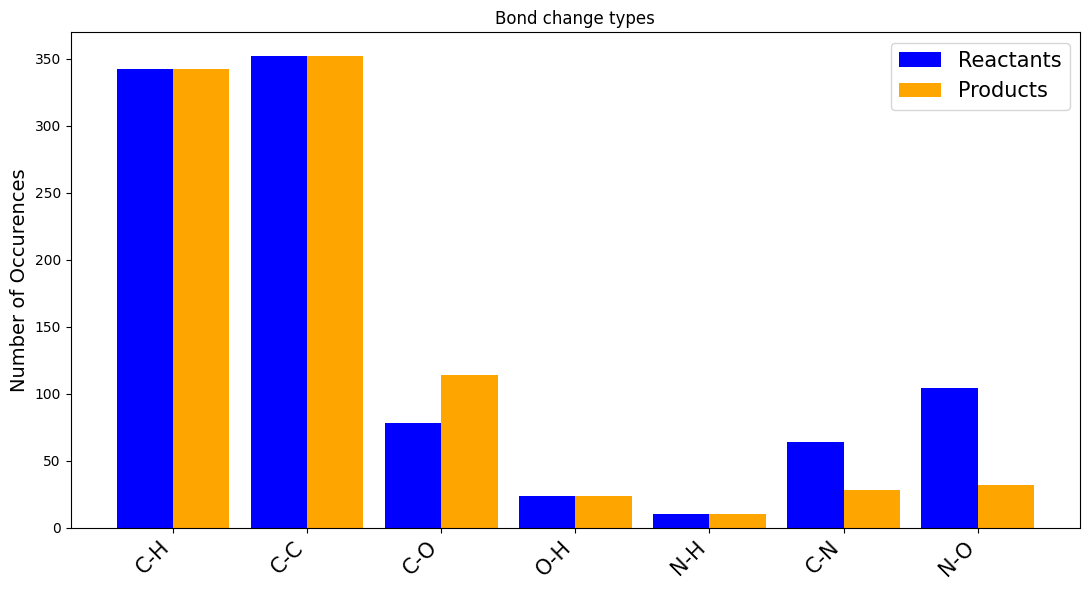

In [ ]:
# =========================
# Seleção manual das ligações a exibir (Reagentes vs Produtos)
# =========================

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- 1) Escolha manual: edite esta lista (ordem = ordem do eixo X) ----
# Exemplos válidos: "C-H", "C-C", "C-O", "O-H", "N-H", "C-N", "N-O"
selected_bonds = ["C-H","C-C","C-O","O-H","N-H", "C-N", "N-O"]

always_exclude = {"H-H","O-O"}

# ---- 2) Carregar planilha de contagens ----
candidates = ["/content/contagem_ligacoes_prod_reag.xlsx"]
path = next((p for p in candidates if os.path.exists(p)), None)
if path is None:
    raise FileNotFoundError("Nenhum arquivo encontrado nos caminhos padrão.")

df = pd.read_excel(path)

# ---- 3) Helpers ----
def parse_bond_col(col):
    m = re.match(r'^(react|prod|delta)_(.+)$', col)
    if not m:
        return None
    pref = m.group(1)
    rest = m.group(2)
    base = rest.split("__", 1)[0]  # remove sufixo de ordem de ligação
    return pref, base

# Normaliza rótulos tipo 'H-O' -> 'O-H'; 'O-C' -> 'C-O'
def canonical_label(label):
    a, b = [x.strip().upper() for x in label.split("-")]
    if "H" in (a, b):
        other = a if b == "H" else b
        return f"{other}-H"
    a2, b2 = sorted((a, b))
    return f"{a2}-{b2}"

# Canonicaliza a lista manual e aplica exclusões fixas
selected_bonds = [canonical_label(x) for x in selected_bonds if canonical_label(x) not in always_exclude]

# ---- 4) Agregar totais (somando todas as linhas/ordens de ligação) ----
totals = {"react": {}, "prod": {}}
for col in df.columns:
    parsed = parse_bond_col(col)
    if parsed is None:
        continue
    pref, base = parsed
    if pref not in ("react","prod"):
        continue
    # aplica exclusão fixa
    if base in always_exclude:
        continue
    s = pd.to_numeric(df[col], errors="coerce").fillna(0).sum()
    totals[pref][base] = totals[pref].get(base, 0) + s

# ---- 5) Montar vetores somente para as ligações selecionadas ----
react_counts = [totals["react"].get(b, 0) for b in selected_bonds]
prod_counts  = [totals["prod"].get(b, 0)  for b in selected_bonds]

# Aviso se algo da lista não existir nos dados (ficará zero)
missing = [b for b in selected_bonds if (b not in totals["react"] and b not in totals["prod"])]
if missing:
    print("Aviso: as seguintes ligações da seleção não foram encontradas na planilha (tratadas como 0):", missing)

# ---- 6) Tabela resumo (opcional salvar CSV) ----
summary = pd.DataFrame({
    "Ligação": selected_bonds,
    "Reagentes_total": react_counts,
    "Produtos_total": prod_counts,
    "Delta (Prod - Reag)": np.array(prod_counts) - np.array(react_counts),
})
summary_path = "/content/resumo_ligacoes_totais__selecionadas.xlsx"
summary.to_excel(summary_path, index=False)
print(f"Resumo salvo em: {summary_path}")

# ---- 7) Gráfico (barras agrupadas) ----
x = np.arange(len(selected_bonds))
width = 0.42

fig, ax = plt.subplots(figsize=(11, 6))
# Change colors here
ax.bar(x - width/2, react_counts, width, label="Reactants", color='blue')
ax.bar(x + width/2, prod_counts,  width, label="Products", color='orange')
#ax.set_yscale("log")
ax.set_ylabel("Number of Occurences", fontsize=14) # Increased font size
#ax.set_xlabel("Bond Type", fontsize=12) # Added and increased font size
ax.set_xticks(x)
ax.set_xticklabels(selected_bonds, rotation=45, ha="right", fontsize=15) # Added fontsize here
ax.set_title("Bond change types")
ax.legend(fontsize=15)  # Increased legend font size
fig.tight_layout()
plt.show() # Added plt.show() to display the plot